In [7]:
%matplotlib inline

import io
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/ms_stock_lstm/MicrosoftStock.csv"   # <-- update if needed
data = pd.read_csv(file_path)

print("\nHead:")
print(data.head())
print("\nInfo:")
print(data.info())
print("\nDescribe:")
print(data.describe())



Head:
    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None

Describe:
               index         open  

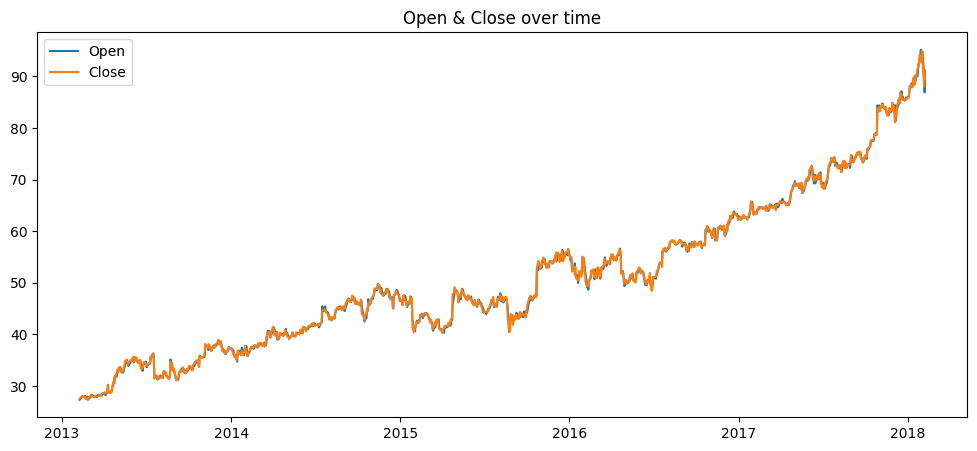

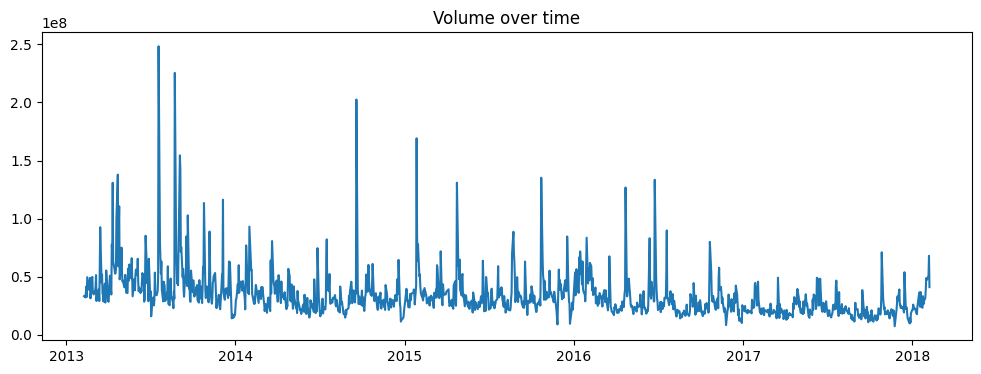

Total: 1259, Train: 1196, Test: 63


In [10]:
# Convert date column
if not np.issubdtype(data['date'].dtype, np.datetime64):
    data['date'] = pd.to_datetime(data['date'])

# Plot Open & Close
plt.figure(figsize=(12,5))
plt.plot(data['date'], data['open'], label="Open")
plt.plot(data['date'], data['close'], label="Close")
plt.title("Open & Close over time")
plt.legend()
plt.show()

# Plot Volume
plt.figure(figsize=(12,4))
plt.plot(data['date'], data['volume'])
plt.title("Volume over time")
plt.show()

# Only Close column
stock_close = data[['date', 'close']].copy()

# Prepare dataset
dataset = stock_close['close'].values.reshape(-1, 1).astype('float32')

train_size = int(len(dataset) * 0.95)
print(f"Total: {len(dataset)}, Train: {train_size}, Test: {len(dataset)-train_size}")


In [11]:
scaler = StandardScaler()
scaled_all = scaler.fit_transform(dataset)

SEQ_LEN = 60
train_scaled = scaled_all[:train_size]

X_train, y_train = [], []
for i in range(SEQ_LEN, len(train_scaled)):
    X_train.append(train_scaled[i-SEQ_LEN:i, 0])
    y_train.append(train_scaled[i, 0])

X_train = np.array(X_train).reshape(-1, SEQ_LEN, 1)
y_train = np.array(y_train)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (1136, 60, 1)
y_train: (1136,)


In [12]:
tf.random.set_seed(42)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mae", metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
EPOCHS = 20
BATCH = 32

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=0.05,
    verbose=1
)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.3394 - root_mean_squared_error: 0.4428 - val_loss: 0.3985 - val_root_mean_squared_error: 0.4340
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1342 - root_mean_squared_error: 0.1765 - val_loss: 0.1531 - val_root_mean_squared_error: 0.2093
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1262 - root_mean_squared_error: 0.1700 - val_loss: 0.0998 - val_root_mean_squared_error: 0.1422
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.1138 - root_mean_squared_error: 0.1531 - val_loss: 0.1064 - val_root_mean_squared_error: 0.1533
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1030 - root_mean_squared_error: 0.1385 - val_loss: 0.1046 - val_root_mean_squared_error: 0.1491
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.1027 - root_mean_squared_error: 0.1362 - val_loss: 0.1688 - val_root_mean_squared_error: 0.2031
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss:

In [14]:
test_scaled = scaled_all[train_size - SEQ_LEN:]
X_test = []

for i in range(SEQ_LEN, len(test_scaled)):
    X_test.append(test_scaled[i-SEQ_LEN:i, 0])

X_test = np.array(X_test).reshape(-1, SEQ_LEN, 1)

y_test_real = dataset[train_size:].reshape(-1, 1)

pred_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(pred_scaled)

print("Predicted:", len(predicted))
print("Actual:", len(y_test_real))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
Predicted: 63
Actual: 63


MAE: 3.3907
RMSE: 3.6636


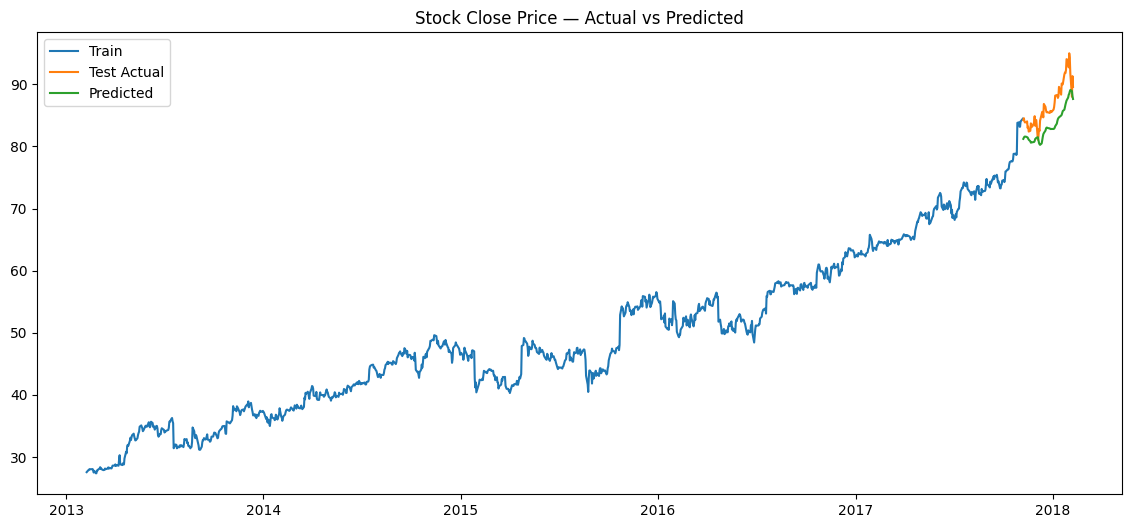

In [15]:
mae_val = mean_absolute_error(y_test_real, predicted)
rmse_val = np.sqrt(mean_squared_error(y_test_real, predicted))

print(f"MAE: {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")

train_df = stock_close.iloc[:train_size].copy()
test_df = stock_close.iloc[train_size:].copy().reset_index(drop=True)
test_df['Predictions'] = predicted.squeeze()

plt.figure(figsize=(14,6))
plt.plot(train_df['date'], train_df['close'], label="Train")
plt.plot(test_df['date'], test_df['close'], label="Test Actual")
plt.plot(test_df['date'], test_df['Predictions'], label="Predicted")
plt.title("Stock Close Price — Actual vs Predicted")
plt.legend()
plt.show()


In [16]:
model.save("msft_lstm_model.keras")
print("Model saved as msft_lstm_model.keras")


Model saved as msft_lstm_model.keras
